In [15]:
import pandas as pd
from collections import Counter
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
import os
import sys

sys.path.append("../")
import src.data_utils as d_u

In [3]:
df = pd.read_csv("../data/raw/АВСОФТ_тест_ML_приложение.csv")

Посмотрим, что из себя представляет целевое значение

<AxesSubplot:>

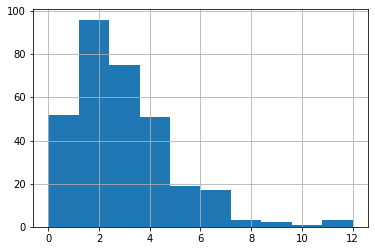

In [14]:
df.bugs.hist()

Посмотрим на имеющиеся данные

In [4]:
df.sample(5)

,repository_name,commit_hash,commit_date,commit_author,commit_message,bugs
113,conductor,d5ec27d7,2020-04-30T11:44:04,Victor,хэш вычисляется у существующих файлов,4
61,standard,366750c8,2020-05-05T10:02:27,Victor,Fix proxy_install,2
190,conductor,188ac88b,2020-03-14T11:22:29,Dabe,Added auth toke,3
236,sensor,3b5d6df1,2020-05-06T11:39:39,Victor,Update filebeat,1
251,sensor,f31bcced,2020-04-30T09:27:27,Victor,права через acl,2


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319 entries, 0 to 318
Data columns (total 6 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   repository_name  319 non-null    object
 1   commit_hash      319 non-null    object
 2   commit_date      319 non-null    object
 3   commit_author    319 non-null    object
 4   commit_message   319 non-null    object
 5   bugs             319 non-null    int64 
dtypes: int64(1), object(5)
memory usage: 15.1+ KB


In [6]:
df.isnull().sum()

repository_name    0
commit_hash        0
commit_date        0
commit_author      0
commit_message     0
bugs               0
dtype: int64

Данных очень мало, пропущенные значения отсутствуют. Числовых признаков нету, не считая целевой переменной. Также необходимо проверить датасет на наличие дубликатов

In [7]:
df.duplicated().sum()

0

Дубликаты отсутствуют...

Сразу посмотрим на признак commit_hash

In [8]:
len(df.commit_hash.unique()) == len(df)

True

Все значения уникальны и не несут какого-либо полезного смысла, поэтому данный признак удаляется

In [9]:
df.drop(columns=["commit_hash"], inplace=True)

Следующий изучаемый нами признак - repository_name

In [10]:
df.repository_name.value_counts()

conductor    114
sensor       102
mlm           41
standard      29
dockers       19
agent         14
Name: repository_name, dtype: int64

In [11]:
df.groupby("repository_name")["bugs"].agg(["sum", "mean", "median", "min", "max"])

,sum,mean,median,min,max
repository_name,,,,,
agent,41,2.928571,3.0,1,5
conductor,343,3.008772,3.0,0,9
dockers,48,2.526316,3.0,0,5
mlm,206,5.024390,4.0,1,12
sensor,233,2.284314,2.0,0,6
standard,85,2.931034,3.0,0,7


Заметно выделяется репозиторий mlm в нем в среднем находят багов больше

У нас всего 6 репозиториев, что довольно немного. Для кодирования данного признака используем One-Hot Encoder

Посмотрим на признак commit_author

In [31]:
df.commit_author.value_counts()

Victor     134
Mallory     67
Wendy       48
Dabe        42
Trudy        9
Eve          9
Carol        4
Peggy        2
Bob          2
Alice        2
Name: commit_author, dtype: int64

In [32]:
df.groupby("commit_author")["bugs"].agg(["sum", "mean", "median", "min", "max"])

,sum,mean,median,min,max
commit_author,,,,,
Alice,1,0.500000,0.5,0,1
Bob,5,2.500000,2.5,2,3
Carol,6,1.500000,1.0,0,4
Dabe,101,2.404762,2.0,1,6
Eve,32,3.555556,3.0,1,7
Mallory,213,3.179104,3.0,0,8
Peggy,7,3.500000,3.5,1,6
Trudy,19,2.111111,2.0,1,4
Victor,464,3.462687,3.0,0,12


Среди авторов коммитов можно выделить 3 категори: исправивший ОЧ большое кол-во багов, испаравившие больше 10 багов и исправившие меньше или равно 10 багов. Таким образом сразу возникает несколько идей кодирования данного категориального признака. Во-первых, использовать стандартный One-Hot Encoder, но этот вариант кажется не самым разумным в данный момент, так как не хочется раздувать размер признакового пространства при малом количестве обучающих данных. Во-вторых, разделить авторов коммитов на 3 категории и уже к ним применять One-Hot Encoder. В-третьих, мы можем применить Label Encoder, где наибольшее значение будет соответствоватьавтору, который нашел больше всего багов.

Следующим рассмотрим признак commit_date.

In [34]:
df[["repository_name", "commit_author", "commit_date"]]

,repository_name,commit_author,commit_date
0,mlm,Victor,2020-06-12T14:26:12
1,mlm,Victor,2020-06-12T11:53:10
2,mlm,Victor,2020-06-11T15:19:03
3,mlm,Victor,2020-06-11T10:42:29
4,mlm,Victor,2020-06-11T09:25:19
...,...,...,...
314,sensor,Dabe,2020-03-23T12:54:35
315,sensor,Dabe,2020-03-23T12:30:52
316,sensor,Dabe,2020-03-23T11:27:40
317,sensor,Dabe,2020-03-23T11:20:50


Преобразуем столбец commit_date в более удобный для работы формат

In [35]:
df["commit_date"] = pd.to_datetime(df.commit_date)

In [36]:
df["month"] = df.commit_date.apply(lambda x: x.month)
df["week"] = df.commit_date.apply(lambda x: x.week)
df["day"] = df.commit_date.apply(lambda x: x.weekday())
df["hour"] = df.commit_date.apply(lambda x: x.hour)
df["year"] = df.commit_date.apply(lambda x: x.year)

In [37]:
for column in ["year", "month"]:
    print(df[column].value_counts())
    print()

2020    319
Name: year, dtype: int64

4    122
5     83
3     65
6     49
Name: month, dtype: int64



В итоге у нас имеются данные всего навсего за 4 месяца в одном году. Посчитаем статистику по багам для каждого месяца

In [38]:
df.groupby("month")["bugs"].agg(["sum", "mean", "median", "min", "max"])

,sum,mean,median,min,max
month,,,,,
3,215,3.307692,3.0,1,12
4,355,2.909836,3.0,0,8
5,230,2.771084,2.0,0,9
6,156,3.183673,3.0,0,11


Видим, что сильно выделяется 4ый месяц. Меньше всего багов найдено в последнем 6ом месяце, однако это скорее всего связано с тем, что в датасет попало только 12 дней из этого месяца

Тоже самое посмотрим для дней недели и часов

In [39]:
df.groupby("day")["bugs"].agg(["sum", "mean", "median", "min", "max"])

,sum,mean,median,min,max
day,,,,,
0,121,2.951220,2.0,1,7
1,65,2.600000,2.0,0,7
2,253,3.328947,3.0,0,11
3,174,2.852459,3.0,0,9
4,229,2.573034,2.0,0,6
5,40,3.333333,3.0,2,8
6,74,4.933333,3.0,2,12


In [40]:
df.groupby("hour")["bugs"].agg(["sum", "mean", "median", "min", "max"]).sort_values(by="sum", ascending=False)

,sum,mean,median,min,max
hour,,,,,
13,131,2.977273,3.0,0,11
12,113,3.138889,3.0,0,10
16,113,2.897436,2.0,0,7
11,105,2.837838,3.0,0,7
15,100,3.225806,3.0,1,9
17,94,3.916667,2.5,1,12
14,91,3.033333,3.0,1,7
10,78,2.600000,2.0,0,7
9,60,3.157895,3.0,1,7


Можно заметить, что больше всего багов было найдено в будние дни в рабочие часы...

Проверим, уменьшается ли со временем количества найденных в течение дня багов в каждом репозитории

In [41]:
df[df.repository_name == "sensor"]

,repository_name,commit_date,commit_author,commit_message,bugs,month,week,day,hour,year
217,sensor,2020-06-10 10:17:03,Wendy,No more log rotate,2,6,24,2,10,2020
218,sensor,2020-06-04 20:44:51,Wendy,Update rules.yaml,1,6,23,3,20,2020
219,sensor,2020-06-04 20:33:07,Wendy,Добавлен энтрипоинт,1,6,23,3,20,2020
220,sensor,2020-06-04 18:28:36,Wendy,add rules folder,1,6,23,3,18,2020
221,sensor,2020-06-04 16:17:13,Wendy,fix rules.yaml,1,6,23,3,16,2020
...,...,...,...,...,...,...,...,...,...,...
314,sensor,2020-03-23 12:54:35,Dabe,setting hostname,1,3,13,0,12,2020
315,sensor,2020-03-23 12:30:52,Dabe,heralding default dockerfile,2,3,13,0,12,2020
316,sensor,2020-03-23 11:27:40,Dabe,unnesserity /data path permissions setting,3,3,13,0,11,2020
317,sensor,2020-03-23 11:20:50,Dabe,added trapconductor,1,3,13,0,11,2020


In [42]:
for rep_name in df.repository_name.unique():
    print(rep_name)
    print(df[df.repository_name == rep_name].sort_values(by="commit_date").groupby(["week"])["bugs"].agg(["sum", "mean"]))
    print()

mlm
      sum      mean
week               
10     45  7.500000
11     30  6.000000
12     23  4.600000
23     20  3.333333
24     88  4.631579

standard
      sum      mean
week               
18     22  2.750000
19     24  3.428571
20     29  2.900000
21     10  2.500000

agent
      sum      mean
week               
21     30  3.333333
22      2  2.000000
23      5  2.500000
24      4  2.000000

conductor
      sum      mean
week               
11     31  2.818182
12     49  2.578947
13     11  2.200000
14     23  2.300000
15     68  4.000000
16     42  3.500000
17     24  2.666667
18     42  3.230769
19      8  2.666667
20     21  7.000000
21      1  1.000000
22      4  2.000000
23      7  2.333333
24     12  2.000000

dockers
      sum      mean
week               
16     16  3.200000
17      2  2.000000
19      1  1.000000
20      5  2.500000
21      7  2.333333
22      5  2.500000
23      6  2.000000
24      6  3.000000

sensor
      sum      mean
week               
13     26  

Хмммм со временем в части репозиториев число обнаруживаемых багов снижается, но есть и такие, в которых происходят резкие скачки по количеству найденных багов за неделю

Теперь посмотрим на столбец commit_message

In [43]:
df.commit_message.sample(10).values

array(['added deploy scripts',
       'Update .gitignore, adbhoney.yaml, and 25 more files...',
       'setting hostname', 'добавил aiohttp', 'Added docker auth config',
       'смена elk адреса', 'install zabbix',
       'Изменен метод взаимодействия с композами с Popen на check_call.',
       "Merge branch 'master' of ", "Обновить 'src/monitor.py'"],
      dtype=object)

In [44]:
msg_lengths = [len(item) for item in df.commit_message.values]
print(f"Максимальная длина: {max(msg_lengths)}")
print(f"Минимальная длина: {min(msg_lengths)}")
print(f"Медианная длина: {np.median(msg_lengths)}")

Максимальная длина: 86
Минимальная длина: 4
Медианная длина: 26.0


В данном столбце содержатся короткие предложения на русском и английском языках, несущие некоторый смысл о проделанной автором коммита работе. С помощью tfidf или мультиязыковой модели будем получать вектор предположительно несущий часть смысла сообщения, который после с помощью svd или pca будет уменьшаться до приемлемого размера.